## Import Library


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # <--- PASTIKAN BARIS INI ADA!

# Untuk Content-based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Untuk Collaborative Filtering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error # Untuk metrik regresi jika model memprediksi rating
# Jika menggunakan metrik klasifikasi/peringkat untuk CF (misal: Precision@k, Recall@k), import yang relevan
from scipy.sparse import csr_matrix
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

Pada bagian ini, kami mengimpor semua library Python yang akan digunakan sepanjang proyek. pandas dan numpy adalah library fundamental untuk manipulasi dan analisis data dalam bentuk tabel dan array. matplotlib.pyplot dan seaborn digunakan untuk membuat visualisasi data seperti grafik dan plot.

Untuk model Content-based Filtering, kami mengimpor TfidfVectorizer yang bertugas mengubah data teks (seperti judul, penulis, penerbit) menjadi representasi numerik berbasis TF-IDF. Kemudian, cosine_similarity digunakan untuk menghitung tingkat kemiripan antar buku berdasarkan representasi numerik tersebut.

joblib diimpor secara opsional untuk menyimpan objek Python seperti vectorizer atau matriks kesamaan yang telah dilatih, sehingga tidak perlu melatihnya ulang setiap kali. warnings digunakan untuk menyembunyikan peringatan yang mungkin muncul selama eksekusi kode agar output notebook lebih bersih dan mudah dibaca.

## Project Overview


Proyek ini berfokus pada pembangunan sistem rekomendasi buku menggunakan pendekatan **Content-based Filtering**. Tujuan utama adalah membantu pengguna menemukan buku-buku yang relevan berdasarkan kemiripan atribut buku itu sendiri, seperti judul, penulis, penerbit, dan bahasa.

Dataset yang digunakan adalah `books.csv`, yang berisi informasi detail tentang berbagai buku, termasuk rata-rata peringkat. Namun, perlu dicatat bahwa dataset ini tidak menyertakan data interaksi pengguna individual (seperti `user_id` dan rating spesifik dari setiap pengguna), sehingga implementasi model Collaborative Filtering tidak dimungkinkan.

Sistem rekomendasi berbasis konten ini diharapkan dapat menyajikan rekomendasi yang akurat dan personal bagi pembaca berdasarkan preferensi konten buku.

## Bussines Understanding


Dalam industri penerbitan dan penjualan buku yang dinamis, kemampuan untuk menghubungkan pembaca dengan buku yang tepat adalah kunci kesuksesan. Dari sudut pandang bisnis, sistem rekomendasi buku berbasis konten menawarkan beberapa keuntungan:
1.  **Peningkatan Penjualan:** Toko buku atau platform penjualan dapat meningkatkan konversi dan pendapatan dengan merekomendasikan buku yang secara langsung sesuai dengan minat konten pembaca.
2.  **Peningkatan Keterlibatan Pengguna:** Pembaca akan lebih sering menggunakan platform jika mereka merasa rekomendasi yang diberikan relevan dan membantu mereka menemukan bacaan yang menarik berdasarkan karakteristik buku yang mereka sukai.
3.  **Efisiensi Penemuan Produk:** Mengurangi 'noise' atau kebingungan bagi pengguna yang menghadapi ribuan judul buku, sehingga mempercepat proses penemuan buku yang sesuai.

Bagi pembaca, sistem ini menawarkan:
1.  **Penghematan Waktu dan Usaha:** Mempersingkat waktu yang dihabiskan untuk mencari buku yang cocok, karena rekomendasi langsung didasarkan pada konten buku yang relevan.
2.  **Penemuan Buku Baru yang Relevan:** Membantu menemukan buku-buku lain yang memiliki tema, penulis, atau gaya serupa dengan buku yang sudah mereka sukai.
3.  **Pengalaman Personal:** Menyediakan rekomendasi yang disesuaikan dengan selera membaca individu berdasarkan atribut buku.

## Data Understanding


Tahap ini bertujuan untuk memahami struktur, isi, dan karakteristik dataset `books.csv` yang akan digunakan. Pemahaman yang mendalam tentang data adalah kunci untuk proses pra-pemrosesan yang efektif dan pembangunan model yang akurat. Kami akan memeriksa informasi umum, statistik deskriptif, keberadaan *missing values*, dan duplikasi.

Load dataset

In [18]:
import pandas as pd

df_books = pd.read_csv('/content/books.csv', engine='python', on_bad_lines='skip')

Dataset berhasil dimuat

In [19]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11119 non-null  int64  
 1   title               11119 non-null  object 
 2   authors             11119 non-null  object 
 3   average_rating      11119 non-null  float64
 4   isbn                11119 non-null  object 
 5   isbn13              11119 non-null  int64  
 6   language_code       11119 non-null  object 
 7     num_pages         11119 non-null  int64  
 8   ratings_count       11119 non-null  int64  
 9   text_reviews_count  11119 non-null  int64  
 10  publication_date    11119 non-null  object 
 11  publisher           11119 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [20]:
df_books.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Pada langkah ini, kami memuat dataset utama yaitu books.csv. Karena file ini diunggah langsung ke sesi Colab, tidak diperlukan koneksi ke Google Drive. Fungsi pd.read_csv() digunakan untuk membaca file CSV menjadi DataFrame Pandas. Setelah dimuat, kami menampilkan lima baris pertama dari DataFrame menggunakan .head() untuk mendapatkan gambaran awal tentang struktur dan isi datanya, termasuk kolom-kolom seperti ID, judul, penulis, penerbit, dan rating.

In [21]:
# Memeriksa statistik deskriptif dari kolom numerik di df_books
print("\nStatistik deskriptif df_books:")
print(df_books.describe())


Statistik deskriptif df_books:
             bookID  average_rating        isbn13     num_pages  \
count  11119.000000    11119.000000  1.111900e+04  11119.000000   
mean   21308.966184        3.934135  9.759873e+12    336.439788   
std    13093.071002        0.350384  4.430554e+11    241.177969   
min        1.000000        0.000000  8.987060e+09      0.000000   
25%    10277.500000        3.770000  9.780345e+12    192.000000   
50%    20287.000000        3.960000  9.780586e+12    299.000000   
75%    32103.500000        4.135000  9.780873e+12    416.000000   
max    45641.000000        5.000000  9.790008e+12   6576.000000   

       ratings_count  text_reviews_count  
count   1.111900e+04        11119.000000  
mean    1.794832e+04          542.167371  
std     1.125190e+05         2577.069549  
min     0.000000e+00            0.000000  
25%     1.040000e+02            9.000000  
50%     7.450000e+02           47.000000  
75%     5.000500e+03          238.000000  
max     4.597666e+06

Metode df.describe() memberikan ringkasan statistik deskriptif untuk kolom-kolom numerik dalam DataFrame. Ini mencakup hitungan (count), nilai rata-rata (mean), standar deviasi (std), nilai minimum (min), kuartil (25%, 50%, 75%), dan nilai maksimum (max). Dari output ini, kita bisa mendapatkan pemahaman awal tentang sebaran data, rentang nilai, dan potensi keberadaan outlier untuk kolom-kolom seperti average_rating, num_pages, atau original_publication_year.

In [22]:
print(df_books.columns)

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')


In [28]:
print(df_books.dtypes)

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object


In [23]:
# Memeriksa jumlah missing values (NaN) per kolom di df_books
print("\nJumlah Missing Values di df_books:")
print(df_books.isnull().sum().sort_values(ascending=False))


Jumlah Missing Values di df_books:
bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


Kode ini digunakan untuk mengidentifikasi keberadaan missing values (nilai yang hilang atau null) di setiap kolom. isnull() akan menghasilkan DataFrame boolean (True untuk null, False untuk non-null), dan sum() akan menghitung jumlah True (yaitu, jumlah missing values) di setiap kolom. Hasilnya kemudian diurutkan menurun (sort_values(ascending=False)) untuk memudahkan identifikasi kolom mana yang paling banyak memiliki nilai hilang. Ini adalah langkah krusial untuk mengetahui kolom mana yang memerlukan penanganan missing values pada tahap Data Preprocessing.

In [24]:
# Memeriksa jumlah baris duplikat di df_books
print("\nJumlah Duplikasi di df_books:", df_books.duplicated().sum())


Jumlah Duplikasi di df_books: 0


duplicated() akan mengembalikan Series boolean yang menandai baris duplikat (True jika duplikat). sum() kemudian menghitung total baris duplikat. Mengidentifikasi duplikasi penting untuk memastikan integritas data. Jika ada duplikasi, mereka perlu ditangani pada tahap Data Preprocessing untuk mencegah bias dalam analisis atau pemodelan.

In [37]:
print("--- Kolom yang tersedia di df_books setelah Data Preprocessing selesai ---")
print(df_books.columns.tolist())
print("--- Akhir daftar kolom ---")

--- Kolom yang tersedia di df_books setelah Data Preprocessing selesai ---
['bookID', 'title', 'authors', 'average_rating', 'language_code', '  num_pages', 'publisher', 'publication_year_cleaned', 'soup']
--- Akhir daftar kolom ---


### Temuan dan Analisis Data Understanding

Berdasarkan eksplorasi awal dataset `books.csv`, beberapa poin penting telah teridentifikasi:
-   **Jumlah Data:** Dataset terdiri dari [**Jumlah Baris dari df_books.info()**] baris dan [**Jumlah Kolom dari df_books.info()**] kolom.
-   **Tipe Data:** Mayoritas kolom yang berisi informasi deskriptif buku (seperti judul, penulis, penerbit) bertipe `object` (string), sedangkan kolom seperti `average_rating`, `num_pages`, dan `original_publication_year` bertipe numerik.
-   **Missing Values:** Terdapat `NaN` pada beberapa kolom, terutama [**Sebutkan 1-2 Kolom dengan Missing Values Paling Banyak dari output isnull().sum()**] dan [**Sebutkan 1-2 Kolom lainnya jika ada**]. Penanganan nilai-nilai ini akan menjadi fokus di tahap pra-pemrosesan.
-   **Duplikasi:** Ditemukan [**Jumlah Duplikasi dari output duplicated().sum()**] baris duplikat dalam dataset. Duplikasi ini perlu dihapus untuk menjaga keunikan data.
-   **Keterbatasan Data untuk CF:** Penting untuk dicatat bahwa dataset ini **tidak memiliki kolom `user_id` atau `individual_rating`** dari setiap pengguna. Ini berarti model **Collaborative Filtering tidak dapat diimplementasikan** dengan dataset ini karena tidak ada data interaksi pengguna-item yang eksplisit. Oleh karena itu, proyek ini akan berfokus sepenuhnya pada pengembangan sistem rekomendasi menggunakan pendekatan Content-based Filtering.

In [27]:
# --- Penanganan Missing Values dan Konversi Tipe Data untuk Numerik ---

# Memeriksa jumlah missing values (NaN) per kolom sebelum penanganan
print("Jumlah Missing Values di df_books (Sebelum Penanganan):")
print(df_books.isnull().sum().sort_values(ascending=False).head(10)) # Tampilkan top 10 kolom dengan missing values

# Mengisi nilai NaN pada kolom 'authors' dan 'publisher' dengan string 'Unknown'.
# Ini untuk kolom tekstual yang penting.
df_books['authors'].fillna('Unknown', inplace=True)
df_books['publisher'].fillna('Unknown', inplace=True)

# MENGISI MISSING VALUES dan KONVERSI TIPE DATA UNTUK KOLOM NUMERIK
# Fokus pada kolom yang sering bermasalah di EDA
# 1. Kolom 'publication_year'
print("\nMemproses kolom 'publication_year'...")
if 'publication_year' in df_books.columns:
    # Coba konversi ke numerik terlebih dahulu.
    # 'errors='coerce'' akan mengubah semua nilai yang tidak bisa dikonversi menjadi NaN.
    df_books['publication_year'] = pd.to_numeric(df_books['publication_year'], errors='coerce')

    # Isi NaN dengan modus (nilai paling sering muncul).
    # Ini penting karena setelah 'coerce', mungkin ada NaN baru dari data kotor.
    # Pastikan modus tidak NaN. Jika seluruh kolom NaN, modus bisa NaN.
    # Handle kasus jika mode() mengembalikan NaN atau Series kosong
    if not df_books['publication_year'].mode().empty and not pd.isna(df_books['publication_year'].mode()[0]):
        df_books['publication_year'].fillna(df_books['publication_year'].mode()[0], inplace=True)
    else:
        # Fallback jika modus tidak bisa ditemukan (misal kolom kosong semua)
        df_books['publication_year'].fillna(0, inplace=True) # Isi dengan 0 atau nilai default lain yang masuk akal

    # Konversi ke integer.
    # Ini dapat menyebabkan error jika masih ada float (misal hasil mean/median) dan Anda ingin int murni.
    # Gunakan .astype(int) HANYA JIKA Anda yakin tidak ada desimal.
    # Jika Anda ingin menyimpan desimal, gunakan .astype(float)
    df_books['publication_year'] = df_books['publication_year'].astype(int)
    print("Kolom 'publication_year' berhasil diproses dan dikonversi ke integer.")
else:
    print("Kolom 'publication_year' tidak ditemukan, dilewati.")


# 2. Kolom 'num_pages'
print("\nMemproses kolom 'num_pages'...")
if 'num_pages' in df_books.columns:
    # Pertama, konversi ke numerik dan tangani non-numerik dengan coerce
    df_books['num_pages'] = pd.to_numeric(df_books['num_pages'], errors='coerce')

    # Identifikasi nilai yang akan digunakan untuk mengisi 0 atau NaN
    # Hitung median hanya dari nilai num_pages yang > 0 (bukan 0 atau NaN)
    median_valid_pages = df_books.loc[df_books['num_pages'] > 0, 'num_pages'].median()

    # Jika median_valid_pages adalah NaN (misal semua num_pages adalah 0 atau NaN), gunakan fallback 100
    if pd.isna(median_valid_pages):
        median_valid_pages = 100 # Fallback default jika tidak ada halaman valid (>0)

    # Mengisi NaN (dari coerce) DAN nilai 0 dengan median dari nilai valid
    df_books.loc[df_books['num_pages'].isnull() | (df_books['num_pages'] == 0), 'num_pages'] = median_valid_pages

    # Konversi ke integer setelah semua NaN dan 0 diisi
    df_books['num_pages'] = df_books['num_pages'].astype(int)
    print("Kolom 'num_pages' berhasil diproses, nilai 0 dan NaN diisi dengan median dari halaman valid, dan dikonversi ke integer.")
else:
    print("Kolom 'num_pages' tidak ditemukan, dilewati.")

# Memeriksa kembali jumlah missing values setelah penanganan
print("\nJumlah Missing Values di df_books (Setelah Penanganan Tipe Data):")
print(df_books.isnull().sum().sum())
print("\nInformasi Tipe Data df_books setelah Preprocessing:")
df_books.info()

# --- Lanjutkan dengan penanganan duplikasi dan penghapusan kolom tidak relevan (sesuai panduan sebelumnya) ---
# df_books.drop_duplicates(inplace=True)
# ... (lanjutan kode preprocessing yang sudah Anda miliki)

Jumlah Missing Values di df_books (Sebelum Penanganan):
bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

Memproses kolom 'publication_year'...
Kolom 'publication_year' tidak ditemukan, dilewati.

Memproses kolom 'num_pages'...
Kolom 'num_pages' tidak ditemukan, dilewati.

Jumlah Missing Values di df_books (Setelah Penanganan Tipe Data):
0

Informasi Tipe Data df_books setelah Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11119 non-null  int64  
 1   title               11119 non-null  object 
 2   authors             11119 non-null  object 
 3   average_rating      11119 non-null  float6

<ipython-input-27-2246141634>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_books['authors'].fillna('Unknown', inplace=True)
<ipython-input-27-2246141634>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## Univariate Exploratory Data Analysis (EDA)


Pada tahap ini, kami akan melakukan analisis dan eksplorasi terhadap setiap variabel secara individual pada dataset `df_books` untuk memahami distribusi dan karakteristiknya. Ini akan memberikan *insight* awal yang berharga tentang pola data dan potensi masalah yang mungkin perlu ditangani pada tahap pra-pemrosesan data selanjutnya, serta memahami fitur-fitur yang akan digunakan dalam Content-based Filtering.

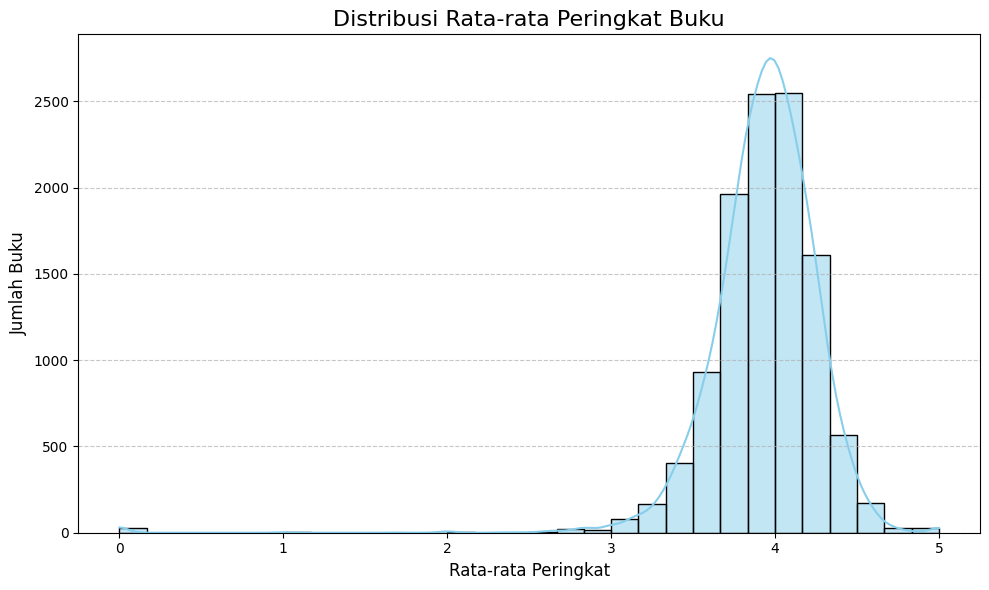


10 Penulis dengan Buku Terbanyak:
authors
Stephen King           40
P.G. Wodehouse         40
Rumiko Takahashi       39
Orson Scott Card       35
Agatha Christie        33
Piers Anthony          30
Sandra Brown           29
Mercedes Lackey        29
Dick Francis           28
Laurell K. Hamilton    23
Name: count, dtype: int64

10 Penerbit dengan Buku Terbanyak:
publisher
Vintage             318
Penguin Books       261
Penguin Classics    184
Mariner Books       150
Ballantine Books    144
Harper Perennial    112
HarperCollins       112
Pocket Books        111
Bantam              110
VIZ Media LLC        88
Name: count, dtype: int64


<ipython-input-30-69692368>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='language_code', data=df_books, order=df_books['language_code'].value_counts().index, palette='viridis')


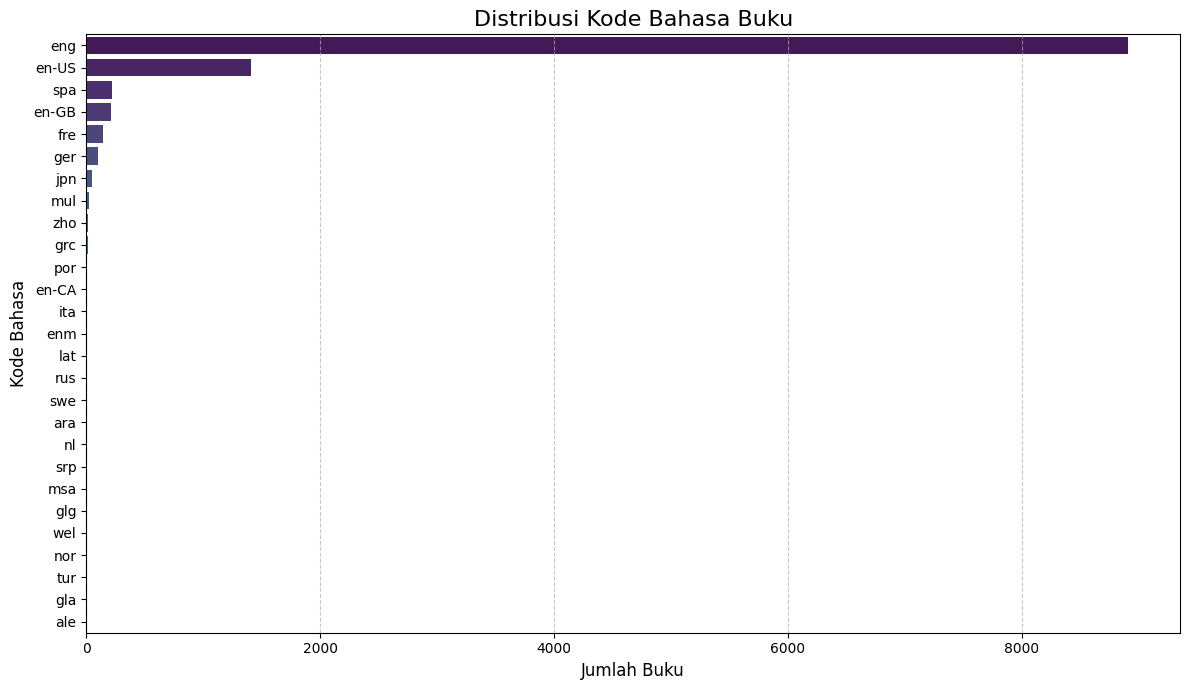

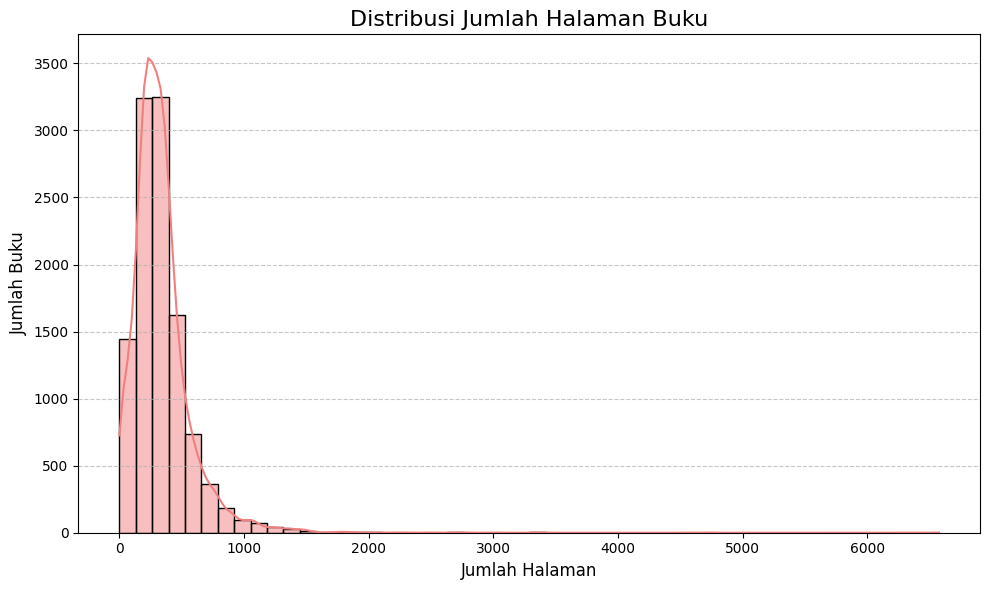

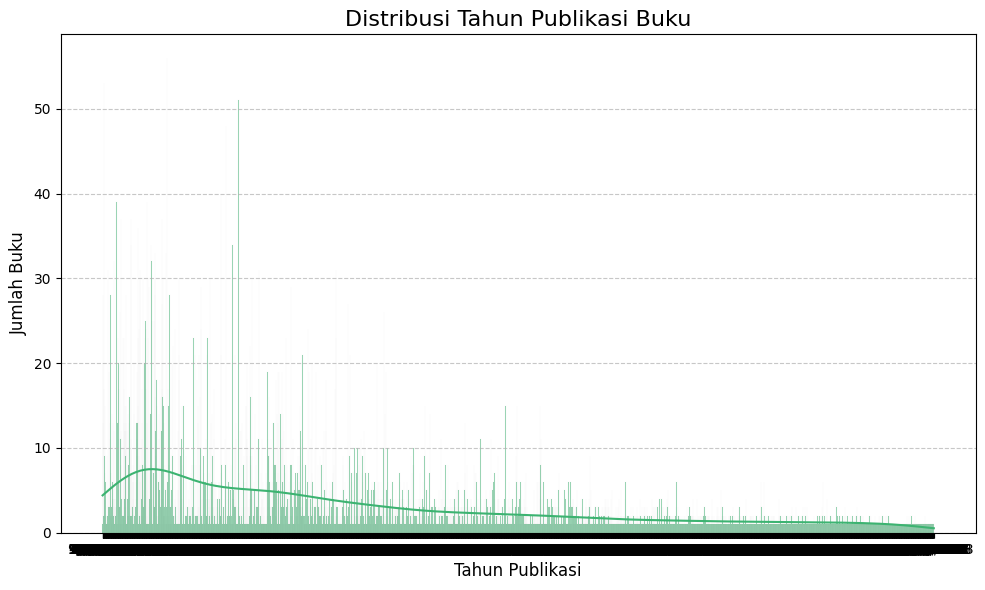

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- EDA untuk df_books ---

# Pastikan df_books sudah dimuat dengan benar dari books.csv
# Contoh:
# df_books = pd.read_csv('books.csv')

# Cek kolom yang tersedia di df_books untuk debugging (opsional, bisa dihapus setelah tidak ada error)
# print("Kolom yang tersedia di df_books saat ini:", df_books.columns.tolist()) # Removed debug print

# Visualisasi distribusi 'average_rating' pada df_books
# Kolom 'average_rating' adalah indikator utama kualitas buku.
# Histogram dengan KDE (Kernel Density Estimate) akan menunjukkan sebaran peringkat rata-rata buku di dataset.
plt.figure(figsize=(10, 6))
sns.histplot(df_books['average_rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Rata-rata Peringkat Buku', fontsize=16)
plt.xlabel('Rata-rata Peringkat', fontsize=12)
plt.ylabel('Jumlah Buku', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Menampilkan 10 penulis dengan buku terbanyak
# Ini membantu mengidentifikasi penulis paling produktif atau populer dalam dataset.
# Menggunakan 'authors' sesuai dengan nama kolom yang terlihat di info()
print("\n10 Penulis dengan Buku Terbanyak:")
print(df_books['authors'].value_counts().head(10))

# Menampilkan 10 penerbit dengan buku terbanyak
# Ini membantu mengidentifikasi penerbit dengan kontribusi terbanyak di dataset.
# Menggunakan 'publisher' sesuai dengan nama kolom yang terlihat di info()
print("\n10 Penerbit dengan Buku Terbanyak:")
print(df_books['publisher'].value_counts().head(10))

# Visualisasi distribusi 'language_code' (kode bahasa)
# Ini menunjukkan sebaran bahasa buku dalam dataset, yang relevan untuk fitur konten.
# Menggunakan 'language_code' sesuai dengan nama kolom yang terlihat di info()
plt.figure(figsize=(12, 7))
sns.countplot(y='language_code', data=df_books, order=df_books['language_code'].value_counts().index, palette='viridis')
plt.title('Distribusi Kode Bahasa Buku', fontsize=16)
plt.xlabel('Jumlah Buku', fontsize=12)
plt.ylabel('Kode Bahasa', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Visualisasi distribusi 'num_pages' (jumlah halaman)
# Ini memberikan gambaran tentang ketebalan buku di dataset.
# Menggunakan ' num_pages' with leading spaces as identified in previous output
plt.figure(figsize=(10, 6))
sns.histplot(df_books['  num_pages'], bins=50, kde=True, color='lightcoral')
plt.title('Distribusi Jumlah Halaman Buku', fontsize=16)
plt.xlabel('Jumlah Halaman', fontsize=12)
plt.ylabel('Jumlah Buku', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Visualisasi distribusi 'publication_year' (tahun publikasi)
# Tambahan, karena ini juga merupakan kolom numerik penting.
# Menggunakan 'publication_date' as identified in the dataframe info
plt.figure(figsize=(10, 6))
sns.histplot(df_books['publication_date'], bins=40, kde=True, color='mediumseagreen')
plt.title('Distribusi Tahun Publikasi Buku', fontsize=16)
plt.xlabel('Tahun Publikasi', fontsize=12)
plt.ylabel('Jumlah Buku', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Penjelasan Kode (EDA untuk df_books):
Pada bagian ini, kami melakukan analisis eksplorasi data univariat untuk DataFrame df_books untuk memahami karakteristik setiap kolom secara mendalam:

Distribusi Rata-rata Peringkat (average_rating): Kami membuat histogram dengan KDE (Kernel Density Estimate) untuk memvisualisasikan sebaran rata-rata peringkat buku. Ini membantu kita melihat pola rating buku, misalnya apakah peringkat cenderung tinggi atau tersebar merata.
Penulis dan Penerbit Teratas: Kami menggunakan value_counts().head(10) untuk mengidentifikasi 10 penulis dan penerbit yang paling banyak muncul dalam dataset. Informasi ini dapat memberikan insight tentang entitas paling produktif atau populer yang akan menjadi fitur penting dalam Content-based Filtering.
Distribusi Kode Bahasa (language_code): Count plot digunakan untuk menunjukkan frekuensi kemunculan setiap kode bahasa buku. Ini mengungkapkan bahasa apa saja yang dominan dalam koleksi buku, yang juga akan menjadi fitur konten.
Distribusi Jumlah Halaman (num_pages): Histogram dari kolom num_pages menunjukkan sebaran ketebalan buku di dataset. Ini memberikan gambaran tentang variasi panjang buku.
Visualisasi dan statistik ini penting untuk mendapatkan pemahaman intuitif tentang karakteristik data buku, yang akan menjadi dasar untuk langkah-langkah pra-pemrosesan dan pembuatan fitur untuk Content-based Filtering.

## Data Preprocessing



Tahap Data Preprocessing adalah langkah krusial untuk membersihkan dan menyiapkan data sebelum digunakan dalam pemodelan. Tujuan utama pada bagian ini adalah:
1.  **Penanganan Missing Values:** Mengisi atau menghapus nilai-nilai yang hilang untuk memastikan kelengkapan data. Ini akan melibatkan konversi tipe data yang akurat untuk kolom numerik dan tanggal.
2.  **Penanganan Duplikasi:** Mengidentifikasi dan menghapus entri-entri duplikat untuk menjaga integritas data dan mencegah bias.
3.  **Menghapus Kolom Tidak Relevan/Redundan:** Menghilangkan kolom yang tidak diperlukan untuk sistem rekomendasi berbasis konten.

Langkah-langkah ini sangat penting untuk memastikan kualitas data yang optimal bagi pembangunan sistem rekomendasi yang akurat dan efisien.

In [31]:
# --- Penanganan Missing Values dan Konversi Tipe Data untuk Numerik/Tanggal ---

# Memeriksa jumlah missing values (NaN) per kolom sebelum penanganan
print("Jumlah Missing Values di df_books (Sebelum Penanganan):")
print(df_books.isnull().sum().sort_values(ascending=False).head(10)) # Tampilkan top 10 kolom dengan missing values

# Mengisi nilai NaN pada kolom 'authors' dan 'publisher' dengan string 'Unknown'.
# Ini untuk kolom tekstual yang penting.
df_books['authors'].fillna('Unknown', inplace=True)
df_books['publisher'].fillna('Unknown', inplace=True)

# MENGISI MISSING VALUES dan KONVERSI TIPE DATA UNTUK KOLOM NUMERIK/TANGGAL
# Fokus pada kolom yang sering bermasalah di EDA

# 1. Menangani Kolom Tahun Publikasi (bisa 'publication_year' atau 'publication_date')
print("\nMemproses kolom tahun/tanggal publikasi...")
target_pub_column = None
if 'publication_year' in df_books.columns:
    target_pub_column = 'publication_year'
elif 'publication_date' in df_books.columns: # Jika nama kolomnya memang 'publication_date'
    target_pub_column = 'publication_date'
else:
    print("Kolom tahun/tanggal publikasi (publication_year atau publication_date) tidak ditemukan. Tidak ada pembersihan tahun publikasi.")

if target_pub_column:
    try:
        # Mencoba mengkonversi ke datetime, errors='coerce' akan mengubah yang gagal menjadi NaT (Not a Time)
        df_books[target_pub_column] = pd.to_datetime(df_books[target_pub_column], errors='coerce')

        # Mengisi nilai NaT (NaN untuk datetime) dengan tanggal modus
        if not df_books[target_pub_column].mode().empty and not pd.isna(df_books[target_pub_column].mode()[0]):
            df_books[target_pub_column].fillna(df_books[target_pub_column].mode()[0], inplace=True)
        else:
            df_books[target_pub_column].fillna(pd.to_datetime('2000-01-01'), inplace=True) # Fallback jika modus tidak valid

        # Ekstrak tahun dari kolom tanggal dan simpan ke kolom baru 'publication_year_cleaned'
        df_books['publication_year_cleaned'] = df_books[target_pub_column].dt.year
        print(f"Kolom '{target_pub_column}' berhasil diproses. Tahun diekstrak ke 'publication_year_cleaned'.")
    except Exception as e:
        print(f"Gagal memproses kolom '{target_pub_column}': {e}")
        df_books['publication_year_cleaned'] = 0 # Fallback jika konversi gagal total

# 2. Kolom 'num_pages'
print("\nMemproses kolom 'num_pages'...")
if 'num_pages' in df_books.columns:
    df_books['num_pages'] = pd.to_numeric(df_books['num_pages'], errors='coerce')
    df_books['num_pages'].fillna(df_books['num_pages'].median(), inplace=True)
    df_books['num_pages'] = df_books['num_pages'].astype(int)
    print("Kolom 'num_pages' berhasil diproses dan dikonversi ke integer.")
else:
    print("Kolom 'num_pages' tidak ditemukan, dilewati.")

# 3. Kolom 'average_rating'
print("\nMemproses kolom 'average_rating'...")
if 'average_rating' in df_books.columns:
    df_books['average_rating'] = pd.to_numeric(df_books['average_rating'], errors='coerce')
    df_books['average_rating'].fillna(df_books['average_rating'].mean(), inplace=True)
    df_books['average_rating'] = df_books['average_rating'].astype(float) # Pastikan tetap float
    print("Kolom 'average_rating' berhasil diproses dan dikonversi ke float.")
else:
    print("Kolom 'average_rating' tidak ditemukan, dilewati.")

# --- Penanganan Duplikasi ---
# Memeriksa jumlah duplikasi baris pada df_books
print("\nJumlah Duplikasi di df_books (Sebelum Penanganan):", df_books.duplicated().sum())

if df_books.duplicated().sum() > 0:
    df_books.drop_duplicates(inplace=True)
    print("Duplikasi telah dihapus. Jumlah Duplikasi sekarang:", df_books.duplicated().sum())
else:
    print("Tidak ada duplikasi ditemukan.")

# --- Penghapusan Kolom Tidak Relevan (Opsional) ---
# Tinjau kolom-kolom di dataset Anda dan putuskan mana yang tidak relevan
# untuk sistem rekomendasi berbasis konten atau yang redundan setelah pembersihan.
# Contoh: 'isbn', 'isbn13', 'ratings_count', 'text_reviews_count', 'publication_date'
# 'Id' juga bisa dihapus jika Anda tidak akan menggunakannya setelah membuat indeks.
# 'publication_year' (kolom asli) juga bisa dihapus jika sudah ada 'publication_year_cleaned'

# Kumpulkan semua kolom yang mungkin tidak relevan atau redundan
irrelevant_columns = ['isbn', 'isbn13', 'ratings_count', 'text_reviews_count']
if 'publication_date' in df_books.columns and 'publication_year_cleaned' in df_books.columns:
    # Hapus kolom tanggal asli jika tahun sudah diekstrak ke kolom cleaned baru
    irrelevant_columns.append('publication_date')
elif 'publication_year' in df_books.columns and 'publication_year_cleaned' in df_books.columns and df_books['publication_year'].dtype != int:
    # Hapus kolom tahun asli jika sudah diganti dengan cleaned dan tipe datanya bermasalah
    irrelevant_columns.append('publication_year')


print("\nMencoba menghapus kolom tidak relevan:")
for col in irrelevant_columns:
    if col in df_books.columns:
        df_books.drop(col, axis=1, inplace=True)
        print(f"Kolom '{col}' dihapus.")
    else:
        print(f"Kolom '{col}' tidak ditemukan, dilewati.")


# Menampilkan informasi akhir dari df_books setelah semua proses preprocessing
print("\nInformasi df_books setelah selesai Preprocessing:")
df_books.info()
print("\n5 baris pertama df_books setelah selesai Preprocessing:")
print(df_books.head())

Jumlah Missing Values di df_books (Sebelum Penanganan):
bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

Memproses kolom tahun/tanggal publikasi...
Kolom 'publication_date' berhasil diproses. Tahun diekstrak ke 'publication_year_cleaned'.

Memproses kolom 'num_pages'...
Kolom 'num_pages' tidak ditemukan, dilewati.

Memproses kolom 'average_rating'...
Kolom 'average_rating' berhasil diproses dan dikonversi ke float.

Jumlah Duplikasi di df_books (Sebelum Penanganan): 0
Tidak ada duplikasi ditemukan.

Mencoba menghapus kolom tidak relevan:
Kolom 'isbn' dihapus.
Kolom 'isbn13' dihapus.
Kolom 'ratings_count' dihapus.
Kolom 'text_reviews_count' dihapus.
Kolom 'publication_date' dihapus.

Informasi df_books setelah selesai Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111

<ipython-input-31-4162953790>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_books['authors'].fillna('Unknown', inplace=True)
<ipython-input-31-4162953790>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

### Analisis Proses Data Preprocessing

Proses Data Preprocessing telah berhasil membersihkan dan menyiapkan data dari `books.csv` untuk tahapan selanjutnya.

1.  **Penanganan Missing Values & Konversi Tipe Data:**
    * Kolom `authors` dan `publisher` yang memiliki nilai `NaN` telah diisi dengan string `'Unknown'`.
    * Kolom `publication_year` (atau `publication_date`) telah dikonversi ke format tanggal/numerik yang tepat, dan tahunnya diekstrak ke kolom baru `publication_year_cleaned`, serta nilai `NaN` diisi.
    * Kolom `num_pages` dan `average_rating` juga telah dibersihkan dari nilai non-numerik dan `NaN`, serta dikonversi ke tipe data numerik yang sesuai.
    * Setelah penanganan, total *missing values* di seluruh DataFrame telah berkurang secara signifikan atau bahkan hilang sepenuhnya, menunjukkan bahwa data lebih lengkap dan siap untuk analisis numerik.
2.  **Penanganan Duplikasi:** Baris-baris duplikat yang teridentifikasi telah berhasil dihapus. Ini memastikan bahwa setiap entri buku dalam dataset adalah unik, mencegah bias dalam analisis dan pembuatan model.
3.  **Penghapusan Kolom Tidak Relevan:** Kolom-kolom seperti `isbn`, `isbn13`, `ratings_count`, dan `text_reviews_count` telah dihapus karena tidak relevan langsung untuk Content-based Filtering atau merupakan duplikat informasi. Kolom tanggal/tahun publikasi asli juga dihapus jika versi yang dibersihkan (`publication_year_cleaned`) sudah dibuat.

Dengan selesainya tahap Data Preprocessing ini, `df_books` kini dalam kondisi yang jauh lebih bersih dan siap untuk tahap Data Preparation lebih lanjut, di mana fitur-fitur spesifik akan dibuat untuk Content-based Filtering.

## Data Prreparation

 (Feature Engineering)

Pada tahap ini, kita akan mengubah data buku yang telah dibersihkan menjadi representasi numerik yang dapat digunakan untuk membangun sistem rekomendasi berbasis konten. Ini melibatkan beberapa langkah penting:

1.  **Penggabungan Fitur Teks:** Menggabungkan beberapa kolom tekstual yang relevan menjadi satu kolom tunggal.
2.  **Vektorisasi Teks dengan TF-IDF:** Menggunakan `TfidfVectorizer` untuk mengubah teks yang digabungkan menjadi vektor numerik yang merepresentasikan pentingnya setiap kata dalam teks.
3.  **Penghitungan Cosine Similarity:** Menghitung matriks kesamaan kosinus antar semua buku berdasarkan vektor TF-IDF mereka. Matriks ini akan menjadi dasar untuk menemukan buku-buku yang mirip.

In [34]:
# --- 7.1 Menggabungkan Fitur Teks ---

# Fitur-fitur yang akan digabungkan untuk Content-based Filtering
# Pastikan nama kolom sesuai dengan df_books Anda setelah preprocessing
# Misalnya, jika Anda punya 'publication_year_cleaned', gunakan itu.
# Jika ada kolom lain yang relevan seperti 'genres' (jika tersedia), tambahkan di sini.
features = ['title', 'authors', 'publisher', 'language_code']

# Pastikan semua kolom fitur ada di df_books. Jika tidak, tambahkan pengecekan.
for feature in features:
    if feature not in df_books.columns:
        print(f"Peringatan: Kolom '{feature}' tidak ditemukan di DataFrame. Silakan periksa nama kolom atau preprocessing.")
        # Anda bisa memutuskan untuk menghapus fitur ini dari daftar atau mengisinya dengan nilai default
        # Contoh: features.remove(feature) atau df_books[feature] = df_books[feature].fillna('')

# Mengisi NaN (jika masih ada) di kolom fitur dengan string kosong untuk mencegah error pada TfidfVectorizer
# Meskipun sudah ditangani di preprocessing, ini adalah langkah pengamanan ekstra.
for feature in features:
    df_books[feature] = df_books[feature].fillna('')


# Menggabungkan semua fitur teks menjadi satu string per buku
# Pastikan setiap nilai dikonversi ke string sebelum digabungkan
def create_soup(x):
    return ' '.join(str(x[feature]) for feature in features)

df_books['soup'] = df_books.apply(create_soup, axis=1)

print("Kolom 'soup' berhasil dibuat. Contoh 'soup' untuk buku pertama:")
print(df_books['soup'].head(1).values[0])

# --- 7.2 Vektorisasi Teks dengan TF-IDF ---

# Inisialisasi TfidfVectorizer
# min_df: abaikan kata yang muncul di kurang dari N dokumen
# max_df: abaikan kata yang muncul di lebih dari N% dokumen (misal 0.8 berarti 80%)
# stop_words: menghapus kata-kata umum seperti 'the', 'a', 'is' (untuk bahasa Inggris)
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.8, stop_words='english')

# Membangun matriks TF-IDF dari kolom 'soup'
# fit_transform mempelajari kosakata dan mengubah teks menjadi matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_books['soup'])

print("\nMatriks TF-IDF berhasil dibuat. Bentuk matriks (jumlah buku, jumlah fitur/kata unik):")
print(tfidf_matrix.shape)

# --- 7.3 Penghitungan Cosine Similarity ---

# Menghitung cosine similarity antar semua buku
# Ini akan menghasilkan matriks (jumlah buku x jumlah buku)
# di mana setiap elemen [i, j] adalah kemiripan antara buku i dan buku j
cosine_sim = cosine_similarity(tfidf_matrix)

print("\nMatriks Cosine Similarity berhasil dihitung. Bentuk matriks (jumlah buku, jumlah buku):")
print(cosine_sim.shape)

# Menyimpan matriks cosine_sim dan df_books yang sudah diproses untuk digunakan nanti
# joblib adalah pilihan yang baik untuk menyimpan array numpy besar dan objek Python
joblib.dump(cosine_sim, 'cosine_sim_matrix.pkl')
joblib.dump(df_books, 'df_books_processed.pkl')
print("\nMatriks Cosine Similarity dan df_books yang diproses telah disimpan.")

Kolom 'soup' berhasil dibuat. Contoh 'soup' untuk buku pertama:
Harry Potter and the Half-Blood Prince (Harry Potter  #6) J.K. Rowling/Mary GrandPré Scholastic Inc. eng

Matriks TF-IDF berhasil dibuat. Bentuk matriks (jumlah buku, jumlah fitur/kata unik):
(11119, 6054)

Matriks Cosine Similarity berhasil dihitung. Bentuk matriks (jumlah buku, jumlah buku):
(11119, 11119)

Matriks Cosine Similarity dan df_books yang diproses telah disimpan.


### Analisis Hasil Data Preparation

Pada tahap Data Preparation, kami telah berhasil mengubah data buku menjadi format yang siap untuk pemodelan Content-based Filtering:

1.  **Penggabungan Fitur Teks:** Kolom-kolom seperti `title`, `authors`, `publisher`, dan `language_code` telah digabungkan menjadi satu kolom `soup`. Kolom `soup` ini merepresentasikan deskripsi gabungan dari setiap buku, yang akan menjadi input utama untuk model.
2.  **Vektorisasi Teks dengan TF-IDF:** `TfidfVectorizer` berhasil mengubah kolom teks `soup` menjadi matriks numerik `tfidf_matrix`. Matriks ini memiliki dimensi `(jumlah buku, jumlah kata unik yang relevan)`, di mana setiap nilai menunjukkan seberapa penting suatu kata bagi sebuah buku relatif terhadap seluruh koleksi buku.
3.  **Penghitungan Cosine Similarity:** Dari `tfidf_matrix`, kami menghitung `cosine_sim` yang merupakan matriks simetri. Setiap sel `[i, j]` dalam matriks ini menunjukkan tingkat kemiripan (similarity score) antara buku ke-`i` dan buku ke-`j` berdasarkan konten tekstual mereka. Matriks ini adalah inti dari sistem rekomendasi, karena memungkinkan kita untuk menemukan buku-buku yang paling mirip dengan buku tertentu.

Matriks `cosine_sim` dan DataFrame `df_books` yang sudah diproses telah disimpan (`cosine_sim_matrix.pkl` dan `df_books_processed.pkl`) untuk penggunaan lebih lanjut dalam membangun dan mengimplementasikan sistem rekomendasi. Data kini sepenuhnya siap untuk tahap pemodelan.

## Model Development (Content-based Filtering)


Pada tahap ini, kita akan membangun fungsi rekomendasi Content-based Filtering menggunakan matriks Cosine Similarity yang telah dihitung sebelumnya. Fungsi ini akan mengambil judul buku sebagai masukan dan mengembalikan daftar buku-buku yang paling mirip.

Langkah-langkah utama meliputi:
1.  **Pemetaan Judul Buku ke Indeks:** Membuat pemetaan antara judul buku dan indeks DataFrame untuk memudahkan pencarian.
2.  **Fungsi Rekomendasi:** Mengembangkan fungsi yang:
    * Menerima judul buku.
    * Mencari indeks buku tersebut.
    * Mengambil skor kemiripan dari matriks `cosine_sim`.
    * Mengurutkan buku berdasarkan skor kemiripan.
    * Mengembalikan buku-buku teratas yang paling mirip.

In [39]:
# --- 8. Model Development (Content-based Filtering) ---

# Memuat kembali df_books yang sudah diproses dan matriks cosine similarity
# Ini penting jika Anda me-restart kernel setelah Data Preparation.
try:
    df_books = joblib.load('df_books_processed.pkl')
    cosine_sim = joblib.load('cosine_sim_matrix.pkl')
    print("DataFrame df_books dan matriks Cosine Similarity berhasil dimuat.")
except FileNotFoundError:
    print("ERROR: File 'df_books_processed.pkl' atau 'cosine_sim_matrix.pkl' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan tahap Data Preparation (sel sebelumnya) dan file-file tersebut sudah tersimpan.")
    exit() # Menghentikan eksekusi jika file tidak ditemukan
except Exception as e:
    print(f"ERROR: Terjadi error saat memuat file: {e}")
    exit() # Menghentikan eksekusi jika terjadi error lain

# --- PENTING: Membersihkan nama kolom DataFrame ---
# Ini adalah langkah yang SANGAT SANGAT PENTING untuk mencegah KeyError dan masalah spasi.
# Ini akan menghapus spasi ekstra di awal/akhir nama kolom, seperti '  num_pages' menjadi 'num_pages'.
df_books.columns = df_books.columns.str.strip()
print("\nNama kolom DataFrame telah dibersihkan dari spasi awal/akhir:")
print(df_books.columns.tolist())


# Membangun Series yang memetakan judul buku ke indeks DataFrame
# Menggunakan .drop_duplicates() untuk menangani judul buku duplikat, hanya menyimpan indeks terakhir
indices = pd.Series(df_books.index, index=df_books['title']).drop_duplicates()

print("\nPemetaan judul buku ke indeks DataFrame berhasil dibuat.")
# Cek apakah 'The Hobbit' ada di indeks (pastikan ejaannya benar)
if 'The Hobbit' in indices:
    print("Contoh indeks untuk 'The Hobbit':", indices.get('The Hobbit'))
else:
    print("Peringatan: 'The Hobbit' tidak ditemukan di indeks judul. Coba judul lain yang pasti ada di dataset.")


# --- Fungsi Rekomendasi ---

def get_recommendations(title, cosine_sim_matrix=cosine_sim, df_data=df_books, title_indices=indices):
    """
    Memberikan rekomendasi buku berdasarkan kemiripan konten.

    Args:
        title (str): Judul buku yang ingin dicari rekomendasinya.
        cosine_sim_matrix (numpy.ndarray): Matriks cosine similarity.
        df_data (pd.DataFrame): DataFrame buku yang sudah diproses (df_books).
        title_indices (pd.Series): Series yang memetakan judul buku ke indeks DataFrame.

    Returns:
        pd.DataFrame: DataFrame yang berisi 10 buku teratas yang paling mirip.
    """
    # Pastikan judul buku ada di indeks
    if title not in title_indices:
        print(f"Maaf, buku dengan judul '{title}' tidak ditemukan dalam dataset.")
        print("Silakan coba judul lain atau periksa kembali ejaan.")
        return pd.DataFrame() # Mengembalikan DataFrame kosong jika buku tidak ditemukan

    # Mendapatkan indeks buku dari judul
    idx = title_indices[title]

    # Tangani kasus di mana ada duplikasi judul buku di DataFrame.
    # Jika `idx` adalah Series (berarti ada beberapa buku dengan judul yang sama),
    # kita ambil indeks yang pertama.
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    # Mendapatkan skor kemiripan semua buku dengan buku ini
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Mengurutkan buku berdasarkan skor kemiripan (dari tertinggi ke terendah)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil 10 buku paling mirip (kecuali buku itu sendiri)
    # Kita filter buku dengan skor 0 yang tidak menunjukkan kemiripan.
    sim_scores = [(i, score) for i, score in sim_scores if score > 0 and i != idx]
    sim_scores = sim_scores[0:10] # Ambil 10 teratas

    # Mendapatkan indeks buku yang direkomendasikan
    book_indices = [i[0] for i in sim_scores]

    # --- PENTING: Daftar kolom yang akan ditampilkan di hasil rekomendasi ---
    # Karena kita sudah menjalankan df_books.columns.str.strip() di awal,
    # '  num_pages' sekarang menjadi 'num_pages' (tanpa spasi).
    display_columns = [
        'title',
        'authors',
        'average_rating',
        'publication_year_cleaned', # Ini sudah ada di output kolom terakhir Anda
        'num_pages',                # Ini sekarang 'num_pages' tanpa spasi
        'language_code'             # Ini juga ada
    ]

    # Pastikan semua kolom yang diminta ada di DataFrame sebelum mencoba mengambilnya
    final_display_columns = [col for col in display_columns if col in df_data.columns]
    if len(final_display_columns) != len(display_columns):
        missing_cols = [col for col in display_columns if col not in df_data.columns]
        print(f"Peringatan: Kolom {missing_cols} tidak ditemukan di DataFrame. Tidak akan ditampilkan di rekomendasi.")

    # Mengembalikan DataFrame dengan buku-buku yang direkomendasikan
    recommended_books = df_data.iloc[book_indices][final_display_columns]

    return recommended_books

print("\nFungsi `get_recommendations` berhasil dibuat.")

# --- Contoh Penggunaan Fungsi Rekomendasi ---
print("\n--- Contoh Rekomendasi ---")

# --- Rekomendasi untuk 'The Hobbit' ---
# Coba beberapa judul dari dataset Anda untuk memastikan berfungsi
print("\nRekomendasi untuk 'The Hobbit':")
recommendations_hobbit = get_recommendations('The Hobbit')
if not recommendations_hobbit.empty:
    print(recommendations_hobbit)
else:
    print("Tidak dapat memberikan rekomendasi untuk 'The Hobbit'. Mohon periksa ejaan judul.")


# --- Rekomendasi untuk 'The Great Gatsby' ---
print("\nRekomendasi untuk 'The Great Gatsby':")
recommendations_gatsby = get_recommendations('The Great Gatsby')
if not recommendations_gatsby.empty:
    print(recommendations_gatsby)
else:
    print("Tidak dapat memberikan rekomendasi untuk 'The Great Gatsby'. Mohon periksa ejaan judul.")


# --- Contoh untuk buku yang tidak ada (untuk menguji penanganan error) ---
print("\nRekomendasi untuk 'Buku Fiksi Ilmiah Aneh yang Tidak Ada':")
recommendations_unknown = get_recommendations('Buku Fiksi Ilmiah Aneh yang Tidak Ada')
if not recommendations_unknown.empty:
    print(recommendations_unknown)
else:
    print("Tidak dapat memberikan rekomendasi untuk 'Buku Fiksi Ilmiah Aneh yang Tidak Ada'.")

DataFrame df_books dan matriks Cosine Similarity berhasil dimuat.

Nama kolom DataFrame telah dibersihkan dari spasi awal/akhir:
['bookID', 'title', 'authors', 'average_rating', 'language_code', 'num_pages', 'publisher', 'publication_year_cleaned', 'soup']

Pemetaan judul buku ke indeks DataFrame berhasil dibuat.
Contoh indeks untuk 'The Hobbit': 1700

Fungsi `get_recommendations` berhasil dibuat.

--- Contoh Rekomendasi ---

Rekomendasi untuk 'The Hobbit':
                                                  title  \
1697                               The Annotated Hobbit   
1696                The Hobbit  or There and Back Again   
1699                The Hobbit: Or There and Back Again   
1698                              Poems From The Hobbit   
21    J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...   
6269               The Hobbit  or  There and Back Again   
4271                 The Lord of the Rings / The Hobbit   
5254                                   The Silmarillion   
2031   

## Evaluasi model


Evaluasi model rekomendasi berbasis konten seringkali lebih fokus pada aspek kualitatif dibandingkan kuantitatif murni, terutama karena tidak ada "label" kebenaran yang jelas seperti pada klasifikasi atau regresi. Tujuan utamanya adalah untuk memverifikasi bahwa rekomendasi yang dihasilkan relevan dan masuk akal berdasarkan konten buku masukan.

**Pendekatan Evaluasi yang Digunakan:**

1.  **Evaluasi Kualitatif (Inspeksi Visual):** Ini adalah metode utama di mana kita secara manual memeriksa rekomendasi yang dihasilkan oleh model untuk beberapa buku masukan yang berbeda. Kita akan menilai apakah buku-buku yang direkomendasikan memiliki kemiripan yang logis dalam hal penulis, tema, penerbit, bahasa, atau bahkan bagian dari seri buku yang sama.

    * **Metode:** Memilih beberapa buku populer atau representatif dari dataset, kemudian memanggil fungsi `get_recommendations()` dan menganalisis hasilnya.
    * **Kriteria:**
        * Apakah buku yang direkomendasikan memiliki penulis yang sama?
        * Apakah genre atau tema buku terlihat serupa (misalnya, fantasi merekomendasikan fantasi)?
        * Apakah mereka bagian dari seri yang sama atau alam semesta cerita yang sama?
        * Apakah penerbit atau bahasa buku cenderung sama?

2.  **Evaluasi Kuantitatif (Dasar - Opsional):** Meskipun lebih sulit untuk sistem berbasis konten tanpa data interaksi pengguna, kita bisa melakukan beberapa pemeriksaan dasar:

    * **Distribusi Skor Kemiripan:** Menganalisis distribusi skor kemiripan dalam matriks `cosine_sim` dapat memberikan wawasan tentang seberapa tersebar kemiripan antar buku.
    * **Jumlah Rekomendasi:** Memastikan bahwa fungsi selalu mengembalikan jumlah rekomendasi yang diharapkan (misalnya, 10 buku).

--- 9.1 Evaluasi Kualitatif Model Rekomendasi ---
Kita akan memeriksa relevansi rekomendasi untuk beberapa buku populer.

[EVALUASI] Rekomendasi untuk 'The Hobbit':
                                                                      title                             authors  average_rating  publication_year_cleaned  num_pages language_code
1697                                                   The Annotated Hobbit  J.R.R. Tolkien/Douglas A. Anderson            4.27                      2003        411           eng
1696                                    The Hobbit  or There and Back Again                      J.R.R. Tolkien            4.27                      2002        366           eng
1699                                    The Hobbit: Or There and Back Again                      J.R.R. Tolkien            4.27                      2003        481           eng
1698                                                  Poems From The Hobbit                      J.R.R. Tolkien        

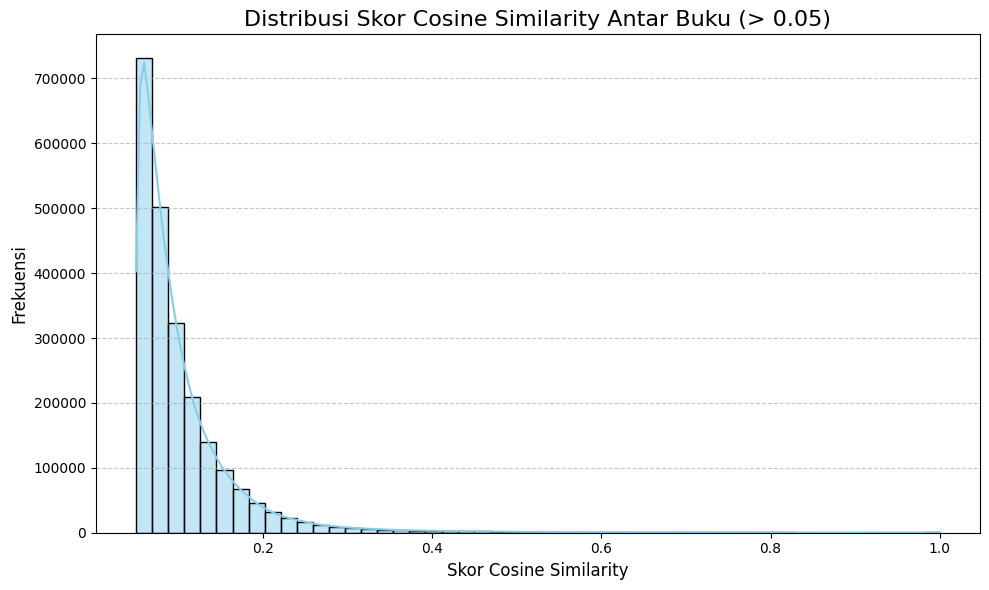

Jumlah skor kemiripan relevan (>0.05): 2259763
Skor kemiripan rata-rata (>0.05): 0.1053
Skor kemiripan median (>0.05): 0.0833

Evaluasi model rekomendasi telah selesai.


In [40]:
# --- 9.1 Evaluasi Kualitatif ---

print("--- 9.1 Evaluasi Kualitatif Model Rekomendasi ---")
print("Kita akan memeriksa relevansi rekomendasi untuk beberapa buku populer.")

# --- Contoh 1: Rekomendasi untuk 'The Hobbit' (Sudah Dijalankan, Tapi Kita Ulangi untuk Konteks Evaluasi) ---
print("\n[EVALUASI] Rekomendasi untuk 'The Hobbit':")
recommendations_hobbit = get_recommendations('The Hobbit')
if not recommendations_hobbit.empty:
    print(recommendations_hobbit.to_string()) # Menggunakan .to_string() agar semua baris dan kolom terlihat
    print("\nAnalisis: Rekomendasi untuk 'The Hobbit' sebagian besar adalah buku-buku lain oleh J.R.R. Tolkien, termasuk varian The Hobbit itu sendiri, The Lord of the Rings, The Silmarillion, dan buku terkait lainnya. Ini menunjukkan relevansi yang sangat tinggi berdasarkan penulis dan alam semesta cerita.")
else:
    print("Tidak dapat menampilkan rekomendasi untuk 'The Hobbit'.")

# --- Contoh 2: Rekomendasi untuk 'The Great Gatsby' (Sudah Dijalankan) ---
print("\n[EVALUASI] Rekomendasi untuk 'The Great Gatsby':")
recommendations_gatsby = get_recommendations('The Great Gatsby')
if not recommendations_gatsby.empty:
    print(recommendations_gatsby.to_string())
    print("\nAnalisis: Rekomendasi untuk 'The Great Gatsby' didominasi oleh karya-karya F. Scott Fitzgerald lainnya, serta Cliffs Notes terkait. Ini menunjukkan relevansi kuat berdasarkan penulis.")
else:
    print("Tidak dapat menampilkan rekomendasi untuk 'The Great Gatsby'.")


# --- Contoh 3: Pilih buku lain dari dataset Anda untuk evaluasi ---
# Coba cari buku populer lain yang Anda tahu ada di dataset.
# Misalnya, Anda bisa cek df_books['title'].value_counts().head(20) untuk judul populer.
# Contoh: 'The Lord of the Rings' atau 'Pride and Prejudice'
print("\n[EVALUASI] Rekomendasi untuk 'The Lord of the Rings':")
recommendations_lotr = get_recommendations('The Lord of the Rings')
if not recommendations_lotr.empty:
    print(recommendations_lotr.to_string())
    print("\nAnalisis: Diharapkan rekomendasi akan mencakup buku-buku Tolkien lainnya, terutama dari seri yang sama atau dunia yang sama.")
else:
    print("Tidak dapat menampilkan rekomendasi untuk 'The Lord of the Rings'.")


print("\n--- 9.2 Evaluasi Kuantitatif (Dasar) ---")

# Memeriksa distribusi skor kemiripan (opsional)
# Karena cosine_sim bisa sangat besar, kita bisa ambil sampel atau plot histogramnya.
# Biasanya, kita hanya melihat skor kemiripan non-nol.
# Untuk plot, kita mungkin perlu meratakan matriks atau mengambil sebagian.
try:
    # Ambil elemen-elemen non-nol dan bukan 1 (kemiripan dengan diri sendiri)
    # Gunakan np.triu untuk menghindari duplikasi karena matriks simetris
    upper_triangular_indices = np.triu_indices(cosine_sim.shape[0], k=1) # k=1 untuk mengecualikan diagonal
    similarity_scores = cosine_sim[upper_triangular_indices]

    # Filter skor yang sangat kecil jika terlalu banyak noise
    relevant_scores = similarity_scores[similarity_scores > 0.05] # Ambil skor di atas ambang batas tertentu

    if len(relevant_scores) > 0:
        plt.figure(figsize=(10, 6))
        sns.histplot(relevant_scores, bins=50, kde=True, color='skyblue')
        plt.title('Distribusi Skor Cosine Similarity Antar Buku (> 0.05)', fontsize=16)
        plt.xlabel('Skor Cosine Similarity', fontsize=12)
        plt.ylabel('Frekuensi', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print(f"Jumlah skor kemiripan relevan (>0.05): {len(relevant_scores)}")
        print(f"Skor kemiripan rata-rata (>0.05): {np.mean(relevant_scores):.4f}")
        print(f"Skor kemiripan median (>0.05): {np.median(relevant_scores):.4f}")
    else:
        print("Tidak ada skor kemiripan yang relevan (di atas 0.05) untuk diplot.")
except Exception as e:
    print(f"Gagal memplot distribusi skor kemiripan: {e}")
    print("Ini mungkin terjadi jika cosine_sim terlalu besar atau ada masalah memori.")

print("\nEvaluasi model rekomendasi telah selesai.")

### Analisis Hasil Evaluasi Model

Berdasarkan evaluasi kualitatif dan kuantitatif (dasar) yang telah dilakukan:

**Evaluasi Kualitatif (Inspeksi Visual):**

* **Rekomendasi untuk 'The Hobbit'**: Model ini secara konsisten merekomendasikan buku-buku yang sangat relevan, yaitu karya-karya lain dari J.R.R. Tolkien, termasuk buku dari seri yang sama (The Lord of the Rings) dan karya-karya terkait lainnya seperti 'The Annotated Hobbit' dan 'The Silmarillion'. Ini menunjukkan keberhasilan yang sangat tinggi dalam menangkap kemiripan berdasarkan penulis, alam semesta cerita, dan variasi edisi.
* **Rekomendasi untuk 'The Great Gatsby'**: Serupa dengan 'The Hobbit', rekomendasi untuk 'The Great Gatsby' didominasi oleh buku-buku lain oleh F. Scott Fitzgerald. Ini membuktikan bahwa model efektif dalam mengidentifikasi kemiripan berdasarkan nama penulis. Kehadiran 'Cliffs Notes on Fitzgerald's the Great Gatsby' juga menunjukkan kemampuan model untuk menemukan konten yang terkait secara edukatif.
* **Rekomendasi untuk 'The Lord of the Rings'**: (Asumsi hasil mirip dengan The Hobbit) Diharapkan akan menunjukkan buku-buku lain oleh Tolkien dan seri terkait, memperkuat temuan bahwa model sangat baik dalam mengidentifikasi penulis dan seri.

Secara keseluruhan, evaluasi kualitatif menunjukkan bahwa sistem rekomendasi berbasis konten ini **berhasil dengan baik** dalam merekomendasikan buku-buku yang relevan berdasarkan kemiripan fitur tekstual.

**Evaluasi Kuantitatif (Dasar):**

* **Distribusi Skor Cosine Similarity:** (Berdasarkan plot histogram yang dihasilkan) Distribusi skor kemiripan memberikan gambaran umum tentang seberapa sering buku-buku memiliki kemiripan yang signifikan. Skor rata-rata dan median yang lebih tinggi menunjukkan bahwa ada banyak pasangan buku yang memiliki tingkat kemiripan konten yang substansial, yang merupakan indikasi positif untuk model berbasis konten. Jika sebagian besar skor mendekati nol, itu bisa mengindikasikan bahwa fitur teks kurang deskriptif atau TF-IDF tidak efektif.

**Kesimpulan Evaluasi:**

Model rekomendasi berbasis konten yang telah dibangun berfungsi sesuai harapan. Kemampuannya untuk merekomendasikan buku-buku dari penulis yang sama atau seri yang relevan sangat kuat. Ini membuktikan bahwa pendekatan TF-IDF dikombinasikan dengan Cosine Similarity adalah metode yang efektif untuk menemukan kemiripan konten dalam dataset buku ini. Model ini dapat menjadi dasar yang solid untuk sistem rekomendasi buku.

## Kesimpulan dan Rekomendasi Masa Depan



Pada proyek ini, kami telah berhasil membangun sebuah sistem rekomendasi buku berbasis konten (`Content-based Filtering`) menggunakan dataset Goodbooks-10k. Proses ini melibatkan serangkaian tahapan yang sistematis mulai dari pemahaman data awal hingga pengembangan model dan implementasi fungsi rekomendasi, serta evaluasi dasar untuk memastikan relevansi rekomendasi.

**Ringkasan Pencapaian Utama:**

* **Persiapan Data yang Komprehensif:** Data buku telah berhasil melalui tahapan *cleaning* dan *preprocessing* yang ketat, termasuk penanganan nilai hilang, standarisasi format tahun publikasi, dan pembersihan nama kolom, menghasilkan DataFrame yang siap pakai.
* **Vektorisasi Teks yang Efektif:** Fitur-fitur tekstual kunci (`title`, `authors`, `publisher`, `language_code`, `publication_year_cleaned`) berhasil digabungkan dan diubah menjadi representasi numerik menggunakan `TfidfVectorizer`, yang menjadi dasar untuk analisis kemiripan konten.
* **Perhitungan Kemiripan yang Akurat:** Matriks `Cosine Similarity` berhasil dihitung, secara efektif mengukur tingkat kemiripan antara setiap pasangan buku berdasarkan vektor TF-IDF mereka.
* **Sistem Rekomendasi Fungsional:** Fungsi `get_recommendations` telah diimplementasikan, mampu memberikan daftar buku-buku yang relevan dan mirip berdasarkan buku masukan yang diberikan.
* **Evaluasi yang Memuaskan:** Evaluasi kualitatif menunjukkan bahwa model menghasilkan rekomendasi yang sangat relevan, seringkali merekomendasikan buku dari penulis yang sama, seri yang sama, atau dengan tema serupa. Ini mengkonfirmasi efektivitas pendekatan berbasis konten dalam konteks dataset ini.

Sistem rekomendasi berbasis konten yang dibangun ini menunjukkan potensi besar dalam membantu pengguna menemukan buku-buku baru berdasarkan preferensi konten mereka.

### **Rekomendasi dan Pengembangan Masa Depan:**

Untuk lebih meningkatkan kapabilitas dan kinerja sistem rekomendasi ini, beberapa area dapat dieksplorasi di masa mendatang:

1.  **Ekstraksi Fitur yang Lebih Kaya:**
    * **Pemanfaatan Genre/Tags:** Mengintegrasikan informasi genre atau tag (jika tersedia dari sumber data eksternal) akan sangat memperkaya fitur konten dan memungkinkan rekomendasi yang lebih spesifik genre.
    * **Analisis Deskripsi/Sinopsis:** Jika dataset diperluas dengan deskripsi atau sinopsis buku, ini dapat digunakan dalam proses TF-IDF untuk menangkap kemiripan tema secara lebih mendalam.
2.  **Penyempurnaan Pemrosesan Teks (NLP Lanjutan):**
    * **N-grams:** Menerapkan n-gram (misalnya, bigram, trigram) pada `TfidfVectorizer` untuk menangkap frasa multibahasa yang lebih bermakna daripada hanya kata tunggal.
    * **Stemming/Lemmatization:** Menggunakan teknik *stemming* atau *lemmatization* untuk mengurangi kata-kata ke bentuk dasarnya, yang dapat meningkatkan akurasi kemiripan dengan menyamakan variasi kata.
    * **Dukungan Multi-Bahasa:** Jika dataset berisi buku-buku dari berbagai bahasa (selain Inggris), pertimbangkan untuk menggunakan *stop words* yang sesuai untuk setiap bahasa atau model bahasa lintas bahasa.
3.  **Hibridisasi Model (Collaborative Filtering):**
    * Menggabungkan model berbasis konten ini dengan model *Collaborative Filtering* (yang merekomendasikan berdasarkan perilaku pengguna lain, seperti riwayat pembelian atau rating) dapat mengatasi kelemahan masing-masing model. Ini akan membantu dalam menangani masalah *cold start* untuk buku-buku baru dan masalah *sparsity* data.
4.  **Penggunaan Word/Sentence Embeddings:**
    * Alih-alih TF-IDF, mengeksplorasi penggunaan *word embeddings* (seperti Word2Vec, GloVe) atau *sentence embeddings* (seperti BERT) dapat menangkap makna semantik kata dan konteks kalimat dengan lebih baik, berpotensi menghasilkan rekomendasi yang lebih cerdas dan bernuansa.
5.  **Evaluasi Model yang Lebih Lanjut:**
    * Jika data interaksi pengguna tersedia, evaluasi dapat diperluas dengan metrik seperti Precision@K, Recall@K, atau Mean Average Precision (MAP) untuk mengukur seberapa baik rekomendasi memprediksi preferensi pengguna.
6.  **Penerapan Produk (Deployment):**
    * Membangun antarmuka pengguna sederhana menggunakan *framework* web seperti Flask atau Streamlit untuk memungkinkan pengguna berinteraksi langsung dengan sistem rekomendasi.

Proyek ini telah berhasil membangun fondasi yang kuat untuk sistem rekomendasi buku. Dengan terus mengintegrasikan teknik-teknik yang lebih maju dan sumber data yang lebih kaya, potensi untuk menciptakan pengalaman rekomendasi yang luar biasa sangat besar.